In [1]:
# author : Myron Kukhta (xkukht01)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import os

In [2]:
class SLR():
    '''
    
    Class for implamintation of Simple Linear Regression (SLR)

    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to dataset
            _dataset [pd.DataFrame]: dataframe with dataset
            _solv [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solv = pd.DataFrame(columns=['cnt', 'Real Y', 'Predict Y', 'B1', 'B2', 'Sum of E', 'R'])


    def StoringDataSet(self)->None:
        '''
        
        Storing dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = os.path.join(os.getcwd(), self.PATH_TO_DATASET)
        
        if not os.path.isfile(path):  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')
        
        self._is_stored_dataset = True


    def _Check_dataset(self)->bool:
        '''

        Description:
            Datasets should not be empty
        
        '''
        if self._dataset.empty:
            return False

        return True

    def _Sampling(self, full_dataset:bool, random_sampling:bool, cnt_sample:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample  [bool]: items number in sample

        '''
        sample = self._dataset.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 100)
        else:
            cnt_samples = cnt_sample
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: prdicted dependet data
        
        '''
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, int, float, int, int, np.array, float, float]:
        '''

        Description:
            Core of SLR
        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data

        '''

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        b2 = np.sum(np.multiply((x - x_mean), (y - y_mean)))/np.sum(np.power((x - x_mean), 2))
        b1 = y_mean - b2*x_mean

        y_predict = b1 + b2*x

        e = y - y_predict  # positive (predict is down), negative (predict is up)

        e_sum = np.sum(e)
        y_sum = np.sum(y)
        y_predict_sum = np.sum(y_predict)

        r = (np.mean(np.multiply(x, y)) - np.mean(x)*np.mean(y))/np.sqrt((np.mean(np.power(x,2))-np.mean(x)**2)*(np.mean(np.power(y,2))-np.mean(y)**2))

        return y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r
        
    def Dataset(self):
        '''
        
        Description:
            Dataset on output
        
        '''
        print(self._dataset)


    
    def InvertExperiment(self):
        self._dataset = self._dataset.transpose()
        print(self._dataset)

    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, cnt_sample:int, viz_with_err:bool, is_reverse:bool=False)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample [int]: items number in sample

        '''
        self._solv.drop(self._solv.index,inplace=True)
        
        if count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            count = 1

        if not self._Check_dataset():  # check data storing
            raise Exception('Warning! You have empty datasets. Please store a data')
        
        for _ in range(count):  # repetitions

            x, y, = self._Sampling(full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            if is_reverse:
                x[:] =x[::-1]
                #y[:] =y[::-1]
            y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r = self._Alg(x, y)  # SLR
            
            self._solv.loc[len(self._solv)] = {'cnt':x.size, 'Real Y':y_sum, 'Predict Y':y_predict_sum, 'B1': b1, 'B2': b2, 'Sum of E':e_sum, 'R': r}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)


        print(self._solv)

    

In [3]:
# Prepare data

SLR_solv = SLR()

SLR_solv.StoringDataSet()

SLR_solv.Dataset()

      Unnamed: 0  price  totsp  livesp  kitsp  dist  metrdist  walk  brick  \
0              1     81     58      40    6.0  12.5         7     1      1   
1              2     75     44      28    6.0  13.5         7     1      0   
2              3    128     70      42    6.0  14.5         3     1      1   
3              4     95     61      37    6.0  13.5         7     1      0   
4              5    330    104      60   11.0  10.5         7     0      1   
...          ...    ...    ...     ...    ...   ...       ...   ...    ...   
2035        2036    110     77      45   10.0  12.0         5     0      0   
2036        2037     95     60      43    6.0   9.0         5     0      0   
2037        2038     95     60      46    5.0  10.5         5     1      0   
2038        2039    129     76      48   10.0  12.5         5     0      0   
2039        2040    103     64      45    7.0  15.5         5     1      0   

      floor  code  
0         1     3  
1         1     6  
2  

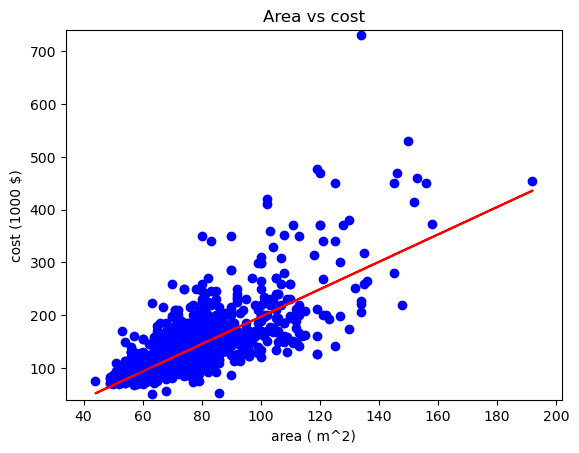

    cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0  2040  260093   260093.0 -62.044844  2.593462 -5.042011e-11  0.756042


In [4]:
# Experiment № 1
# Description: SLR with full dataset

SLR_solv.Experiment(count=1, full_dataset=True, random_sampling=False, cnt_sample=0, viz_with_err=False)

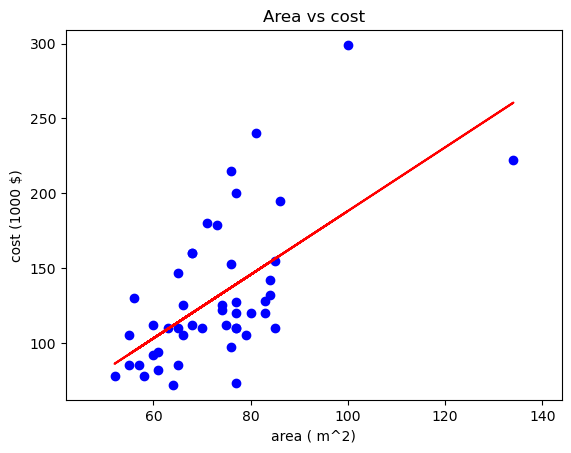

   cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0   47    6128     6128.0 -24.618973  2.127655  3.552714e-13  0.615315


In [5]:
# Experiment № 2
# Description: SLR with datasets sample

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=True, cnt_sample=0, viz_with_err=False)

Point 1: y_original=309, y_predict=223.72183674371325, error=85.27816325628675
Point 2: y_original=145, y_predict=164.794758474389, error=-19.794758474389
Point 3: y_original=105, y_predict=119.26019799354754, error=-14.260197993547536
Point 4: y_original=144, y_predict=151.4022406859062, error=-7.402240685906207
Point 5: y_original=99, y_predict=129.97421222433377, error=-30.97421222433377
Point 6: y_original=122, y_predict=119.26019799354754, error=2.7398020064524644
Point 7: y_original=107, y_predict=143.36673001281653, error=-36.36673001281653
Point 8: y_original=167, y_predict=135.33121933972686, error=31.668780660273143
Point 9: y_original=190, y_predict=237.114354532196, error=-47.11435453219599
Point 10: y_original=107, y_predict=89.7966588588854, error=17.203341141114606
Point 11: y_original=135, y_predict=111.22468732045786, error=23.77531267954214
Point 12: y_original=118, y_predict=129.97421222433377, error=-11.974212224333769
Point 13: y_original=132, y_predict=162.1162549

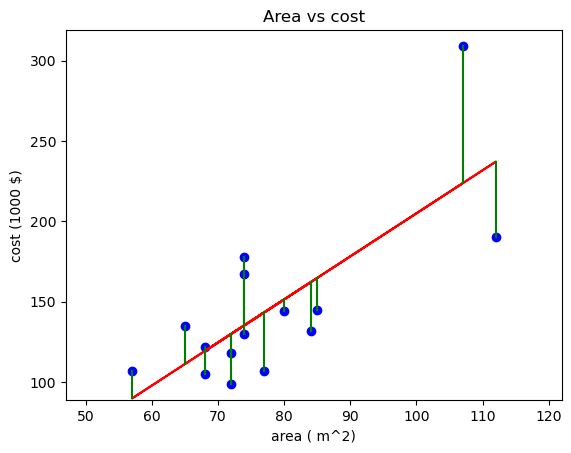

   cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0   15    2188     2188.0 -62.878044  2.678504  1.421085e-13  0.746512


In [6]:
# Experiment № 3
# Description: SLR with datasets sample

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=False, cnt_sample=15,  viz_with_err=True)

In [7]:
# Experiment № 4
# Description: many SLR with datasets sample

SLR_solv.Experiment(count=50, full_dataset=False, random_sampling=True, cnt_sample=0,  viz_with_err=False)

    cnt  Real Y  Predict Y          B1        B2      Sum of E         R
0    92   10907    10907.0 -105.977183  3.287745  3.836931e-13  0.849347
1    30    3989     3989.0  -35.314613  2.276122 -1.705303e-13  0.694512
2    36    4589     4589.0    6.360555  1.657802 -2.557954e-13  0.559846
3    30    3942     3942.0   -7.473559  1.791147 -5.400125e-13  0.840370
4    62    7413     7413.0  -33.564424  2.140698  6.963319e-13  0.756085
5    28    3227     3227.0  -27.118717  2.066524 -3.552714e-13  0.693077
6    43    5202     5202.0  -37.296999  2.263309  1.989520e-13  0.803712
7    86   10734    10734.0   -8.976946  1.851330 -1.364242e-12  0.590919
8    29    3591     3591.0  -48.418352  2.491338 -1.136868e-13  0.725232
9    69    9693     9693.0  -89.989862  3.014654  3.410605e-13  0.732976
10   54    7431     7431.0 -147.356617  3.881023 -2.273737e-13  0.825681
11   84   10029    10029.0  -59.052828  2.539291 -1.506351e-12  0.701977
12   32    3875     3875.0  -31.101923  2.124896  4